In [2]:
import yfinance as yf
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as sps
import pmdarima as arima
from arch import arch_model

In [24]:
spy = yf.download("SPY", start="2010-01-01", end="2025-05-17")
time.sleep(5)
nvda = yf.download("NVDA", start="2010-01-01", end="2025-05-17")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
x = yf.download("X",start="2010-01-01", end="2025-05-17")
x.to_csv("x.csv")

[*********************100%***********************]  1 of 1 completed


In [26]:
nvda.to_csv('nvda.csv')
spy.to_csv('spy.csv')

In [27]:
print(nvda.shape)
print(nvda.columns)
print(spy.columns)

(3867, 5)
MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [28]:
print(spy.iloc[0].shape)
print(2*3774*2)

(5,)
15096


In [3]:
def load_data(file):
    xdat = pd.read_csv(file,skiprows=2)

    xdat.columns = ['Date','Close','High','Low','Open','Volume']
    xdat['Date'] = pd.to_datetime(xdat['Date'])
    
    return xdat

In [4]:
def plot_data(xdat:pd.DataFrame):
    plt.plot(xdat['Date'],xdat['Close'])
    plt.title("Prices")
    plt.show()

    xdat['logReturns'] = np.log1p(xdat.Close).diff()
    xdat['Squared_logReturns'] = (xdat.logReturns)**2

    plt.plot(xdat['Date'],xdat['logReturns'])
    plt.title("log-Returns")
    plt.show()

    plt.plot(xdat['Date'],xdat['Squared_logReturns'])
    plt.title("Squared log-Returns")
    plt.show()

# Asset 1

           Date      Close       High        Low       Open     Volume
3517 2023-12-22  48.811672  49.364462  48.448806  49.176533  252507000
3518 2023-12-26  49.260498  49.581377  48.941618  48.949614  244200000
3519 2023-12-27  49.398445  49.661347  49.066569  49.492412  233648000
3520 2023-12-28  49.503410  49.865274  49.393451  49.624367  246587000
3521 2023-12-29  49.503410  49.978234  48.732700  49.794301  389293000


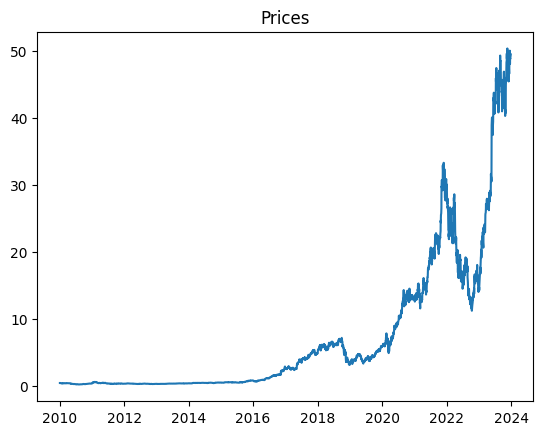

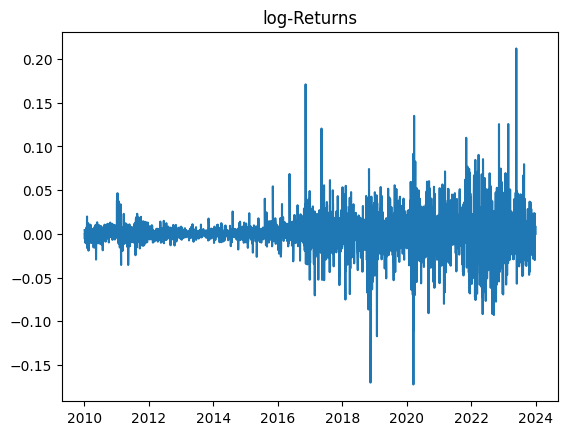

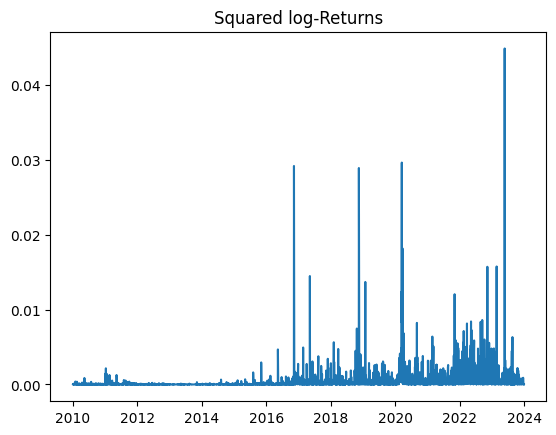

In [5]:
ticket = "nvda"
nvda = load_data(ticket + ".csv")
nvda = nvda[nvda['Date'] <= '2023-12-31']
print(nvda.tail())
plot_data(nvda)

# Asset 2

        Date      Close       High        Low       Open     Volume
0 2010-01-04  85.768448  85.813854  84.391067  85.041918  118944600
1 2010-01-05  85.995491  86.033333  85.405186  85.715478  111579900
2 2010-01-06  86.056046  86.267949  85.844142  85.912251  116074400
3 2010-01-07  86.419304  86.525256  85.654932  85.897108  131091100
4 2010-01-08  86.706863  86.744706  86.018176  86.192237  126402800


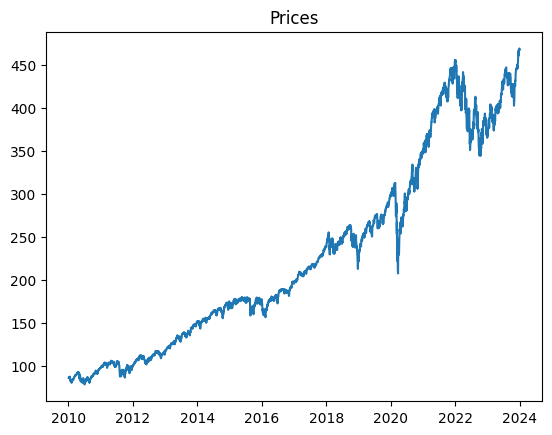

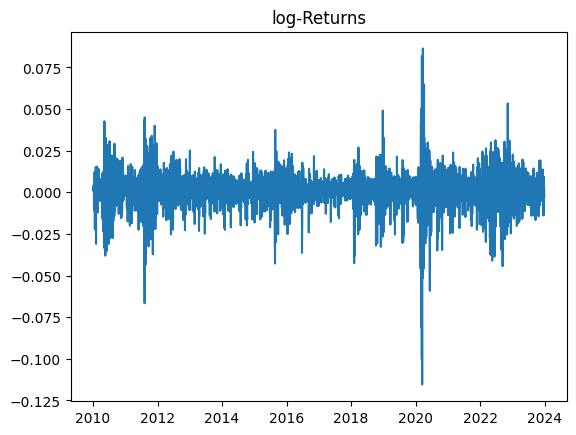

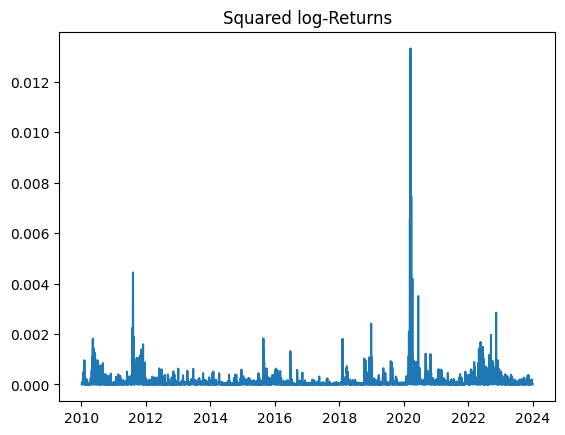

In [6]:
ticket = "spy"
spy = load_data(ticket+".csv")
spy = spy[spy['Date'] <= '2023-12-31']
print(spy.head())
plot_data(spy)

# Risk Comparison

In [7]:
def get_dataset(data, train: bool):
    if train:
        return data[data['Price'] <= '2023-12-31']
    else:
        return data[data['Price'] > '2023-12-31']

def compute_returns(data: pd.DataFrame):
    prices = data["Close"]
    returns = (prices / prices.shift(1)) - 1
    returns = returns.fillna(0)
    return returns

In [8]:
x = pd.read_csv("x.csv",skiprows=[1,2])
data = get_dataset(x,train=True)
x_r = compute_returns(data)

In [183]:
spy = pd.read_csv("spy.csv",skiprows=[1,2])
data = get_dataset(spy,train=True)
spy_r = compute_returns(data)

In [184]:
nvda = pd.read_csv("nvda.csv",skiprows=[1,2])
data = get_dataset(nvda,train=True)
nvda_r = compute_returns(data)

In [11]:
mean_spy=spy_r.expanding().mean()
mean_x=x_r.expanding().mean()
mean_nvda=nvda_r.expanding().mean()

var_spy=spy_r.expanding().var()
var_x=x_r.expanding().var()
var_nvda=nvda_r.expanding().var()

print("NaN in mean_spy:", mean_spy.isna().sum())
print("NaN in mean_x:", mean_x.isna().sum())
print("NaN in mean_nvda:", mean_nvda.isna().sum())

print("Length of mean_spy:", len(mean_spy))
print("Length of mean_x:", len(mean_x))
print("Length of mean_nvda:", len(mean_nvda))

NaN in mean_spy: 0
NaN in mean_x: 0
NaN in mean_nvda: 0
Length of mean_spy: 3522
Length of mean_x: 3522
Length of mean_nvda: 3522


In [12]:
b = mean_spy>mean_x
print(np.sum(b)/len(b))

b2 = var_spy>var_x
print(np.sum(b2)/len(b2))

0.9642248722316865
0.00028392958546280523


In [13]:
b = mean_spy>mean_nvda 
print(np.sum(b)/len(b))

b2 = var_spy>var_nvda
print(np.sum(b2)/len(b2))

0.3940942646223736
0.0


In [14]:
b = mean_nvda>mean_x 
print(np.sum(b)/len(b))

b2 = var_nvda>var_x 
print(np.sum(b2)/len(b2))

0.9327086882453152
0.049403747870528106


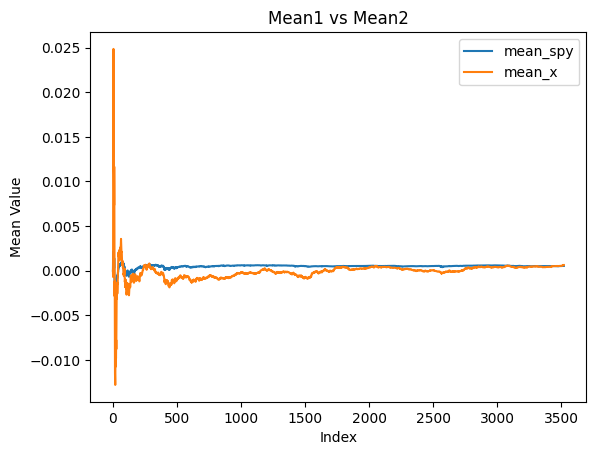

In [15]:
plt.plot(mean_spy, label='mean_spy')
plt.plot(mean_x, label='mean_x')
plt.title('Mean1 vs Mean2')
plt.xlabel('Index')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Minimum Variance Portfolio

In [16]:
def get_mvp(var1,var2,cov):
    std1 = torch.sqrt(var1)
    std2 = torch.sqrt(var2)
    corr = cov/(std1*std2)
    nom = var2 - (corr*std1*std2)
    den = var1 + var2 - (2*corr*std1*std2)
    return nom/den

def get_capital_values(capital,w):
    return w * capital, (1-w)*capital

def get_return_values(returns,w):
    return w * returns + (1-w)*returns

$$\text{VaR}_\alpha = \mu + \sigma \Phi^{-1}(1-\alpha)$$

In [185]:
def get_VaR(alpha, mean, std):
    VaR = mean + (std*sps.norm.ppf(q=1-alpha,loc=0,scale=1))
    return VaR

def get_ES(alpha, mean, std):
    levels5 = np.linspace(0.001,1-alpha,40)
    q5 = sps.norm.ppf(levels5, 0, 1)
    mean5 = q5.mean()
    return mean + std*(mean5)

In [186]:
spy_test = get_dataset(spy,train=False)
spy_test_r = compute_returns(spy_test)

nvda_test = get_dataset(nvda,train=False)
nvda_test_r = compute_returns(nvda_test)

In [187]:
spy_r_log = (np.log1p(spy_r))
spy_r_squared = (np.log1p(spy_r))**2

nvda_r_log = (np.log1p(nvda_r))
nvda_r_squared = (np.log1p(nvda_r))**2

spy_test_r_log = (np.log1p(spy_test_r))
spy_test_r_squared = (np.log1p(spy_test_r))**2

nvda_test_r_log = (np.log1p(nvda_test_r))
nvda_test_r_squared = (np.log1p(nvda_test_r))**2

# ARMA

$$Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$

In [231]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
def get_ARMA(returns):
    arma_model = arima.AutoARIMA(d=0,information_criterion="bic",suppress_warnings=True,trace=True)
    arma_model.fit(y=returns)
    return arma_model

def get_ARMA_predictions(arma_model,n_samples):
    past_prediction = arma_model.predict_in_sample()
    future_prediction = arma_model.predict(n_periods=n_samples)
    return past_prediction,future_prediction

In [241]:
spy_arma = get_ARMA(spy_r_squared)
print(spy_arma.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=-45875.486, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-44459.232, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-45186.198, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-44824.485, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-44212.573, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-45785.197, Time=0.64 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=-45879.160, Time=1.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-45658.791, Time=0.98 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=-45877.462, Time=0.66 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : BIC=-45870.195, Time=0.74 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : BIC=-45878.566, Time=1.52 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : BIC=-45797.785, Time=5.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-45854.946, Time=1.63 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 15.277 sec

In [ ]:
past_spy_variance,future_spy_variance = get_ARMA_predictions(spy_arma,len(spy_test_r))

In [243]:
past_spy_VaR = get_VaR(alpha=0.95,mean=0,std=past_spy_variance**(0.5))
future_spy_VaR = get_VaR(alpha=0.95,mean=0,std=future_spy_variance**(0.5))
print("Past SPY VaR (train):")
print(past_spy_VaR.mean())
print("Future SPY VaR (test):")
print(future_spy_VaR.mean())

past_spy_ES = get_ES(alpha=0.95,mean=0,std=past_spy_variance**(0.5))
future_spy_ES = get_ES(alpha=0.95,mean=0,std=future_spy_variance**(0.5))
print("Past SPY ES (train):")
print(past_spy_ES.mean())
print("Future SPY ES (test):")
print(future_spy_ES.mean())

Past SPY VaR (train):
-0.016115855931064616
Future SPY VaR (test):
-0.01814636515262041
Past SPY ES (train):
-0.02003740221348796
Future SPY ES (test):
-0.022562004700910545


In [244]:
print(f"Train VaR coverage: {(np.where((spy_r_log <= past_spy_VaR), 1, 0)).mean():.4f}")
print(f"Test VaR coverage: {(np.where((spy_test_r_log <= future_spy_VaR), 1, 0)).mean():.4f}")

Train VaR coverage: 0.0565
Test VaR coverage: 0.0377


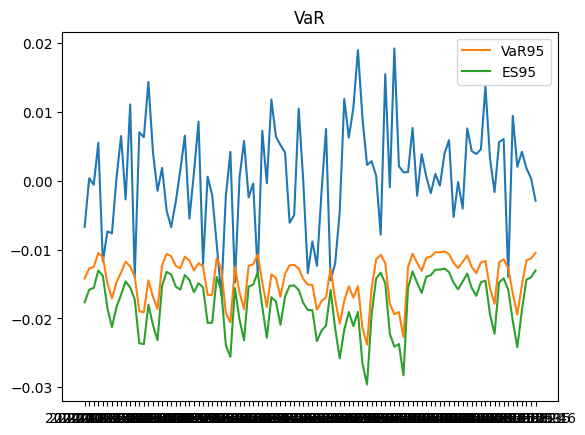

In [245]:
tail = 100
plt.plot(spy['Price'][-tail:],spy_r_log[-tail:])
plt.plot(spy['Price'][-tail:],past_spy_VaR[-tail:], label='VaR95')
plt.plot(spy['Price'][-tail:],past_spy_ES[-tail:], label='ES95')
plt.title("VaR")
plt.legend()
plt.show()

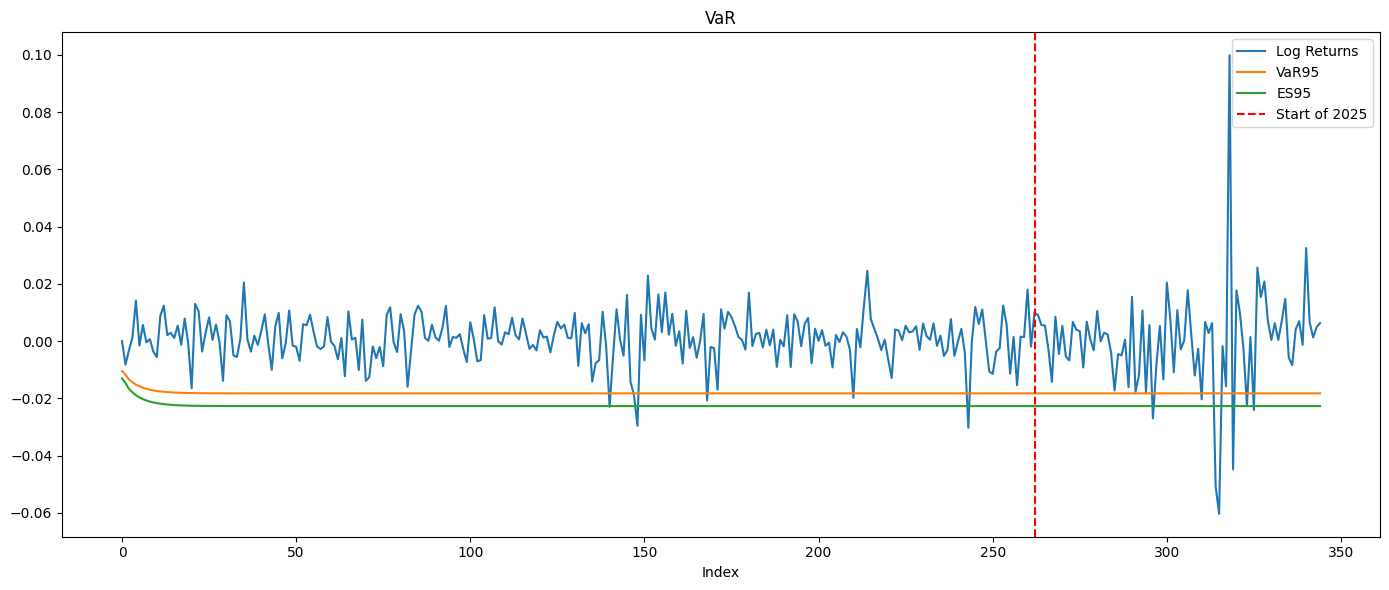

In [246]:
trading_days_2024 = pd.bdate_range(start='2024-01-01', end='2024-12-31')
start_2025_index = len(trading_days_2024)

plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(spy_test_r_log)), spy_test_r_log, label='Log Returns')
plt.plot(np.arange(len(future_spy_VaR)), future_spy_VaR, label='VaR95')
plt.plot(np.arange(len(future_spy_ES)), future_spy_ES, label='ES95')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title("VaR")
plt.xlabel("Index")
plt.legend()
plt.tight_layout()
plt.show()


# GARCH

$$\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \cdots + \alpha_p \epsilon_{t-p}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2 + \cdots + \beta_q \sigma_{t-q}^2$$
$$\sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2$$

In [325]:
from sklearn.preprocessing import StandardScaler

scaler_spy_r_squared = StandardScaler()
spy_r_squared_s = scaler_spy_r_squared.fit_transform(spy_r_squared.values.reshape(-1, 1)).flatten()
spy_test_r_squared_s = scaler_spy_r_squared.transform(spy_test_r_squared.values.reshape(-1, 1)).flatten()

scaler_spy_r_log = StandardScaler()
spy_r_log_s = scaler_spy_r_log.fit_transform(spy_r_log.values.reshape(-1, 1)).flatten()
spy_test_r_log_s = scaler_spy_r_log.transform(spy_test_r_log.values.reshape(-1, 1)).flatten()

In [327]:
def get_GARCH(returns,arma_p,arma_q,rescale):
    distributions = ['normal', 't', 'skewt']
    best_metric = np.inf
    best_model = None

    for dist in distributions:
        for p in range(1, 3):
            for q in range(1, 3):
                try:
                    model = arch_model(returns, vol='GARCH', p=p, q=q, mean="ARX", lags=[arma_q,arma_p], dist=dist,rescale=rescale)
                    res = model.fit(disp='off',update_freq=0, cov_type="robust")
                    if res.bic < best_metric:
                        best_metric = res.bic
                        best_model = res
                        best_config = (p, q, dist)
                    print(f"Try: p={p}, q={q}, dist={dist}, BIC={res.bic:.2f}")
                except:
                    continue

    print("Best config:", best_config)
    print("Best BIC:", best_metric)
    return best_model

In [340]:
def get_GARCH_prediction(garch_result, n_samples):
    # Past predictions
    past_mean = garch_result.params['mu'] if 'mu' in garch_result.params else 0
    past_mean_series = pd.Series([past_mean] * len(garch_result.conditional_volatility))
    past_variance = garch_result.conditional_volatility ** 2

    # Future predictions
    forecast = garch_result.forecast(horizon=n_samples)
    future_mean = forecast.mean.values[-1]
    future_variance = forecast.variance.values[-1]

    return past_mean_series, past_variance, future_mean, future_variance

In [337]:
garch_res = get_GARCH(spy_r_log_s, arma_p=2, arma_q=1, rescale=False)

Try: p=1, q=1, dist=normal, BIC=8451.19
Try: p=1, q=2, dist=normal, BIC=8459.36
Try: p=2, q=1, dist=normal, BIC=8455.36
Try: p=2, q=2, dist=normal, BIC=8462.75
Try: p=1, q=1, dist=t, BIC=8261.40
Try: p=1, q=2, dist=t, BIC=8269.57
Try: p=2, q=1, dist=t, BIC=8262.17
Try: p=2, q=2, dist=t, BIC=8269.62
Try: p=1, q=1, dist=skewt, BIC=8233.07
Try: p=1, q=2, dist=skewt, BIC=8241.24
Try: p=2, q=1, dist=skewt, BIC=8232.28
Try: p=2, q=2, dist=skewt, BIC=8239.69
Best config: (2, 1, 'skewt')
Best BIC: 8232.277859341591


In [338]:
print("GARCH model summary:")
print(garch_res.summary())

GARCH model summary:
                                 AR - GARCH Model Results                                
Dep. Variable:                                 y   R-squared:                       0.002
Mean Model:                                   AR   Adj. R-squared:                  0.001
Vol Model:                                 GARCH   Log-Likelihood:               -4079.39
Distribution:      Standardized Skew Student's t   AIC:                           8176.78
Method:                       Maximum Likelihood   BIC:                           8232.28
                                                   No. Observations:                 3520
Date:                           Fri, May 23 2025   Df Residuals:                     3517
Time:                                   20:17:12   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------

In [344]:
garch_past_spy_mean, garch_past_spy_variance, garch_future_spy_mean, garch_future_spy_variance = get_GARCH_prediction(garch_res, n_samples=len(spy_test_r_log))

In [345]:
garch_past_spy_VaR = get_VaR(alpha=0.95,mean=garch_past_spy_mean,std=garch_past_spy_variance**(0.5))
garch_future_spy_VaR = get_VaR(alpha=0.95,mean=garch_future_spy_mean,std=garch_future_spy_variance**(0.5))
print("Past SPY VaR (train):")
print(garch_past_spy_VaR.mean())
print("Future SPY VaR (test):")
print(garch_future_spy_VaR.mean())

garch_past_spy_ES = get_ES(alpha=0.95,mean=garch_past_spy_mean,std=garch_past_spy_variance**(0.5))
garch_future_spy_ES = get_ES(alpha=0.95,mean=garch_future_spy_mean,std=garch_future_spy_variance**(0.5))
print("Past SPY ES (train):")
print(garch_past_spy_ES.mean())
print("Future SPY ES (test):")
print(future_spy_ES.mean())

Past SPY VaR (train):
-1.451326468798566
Future SPY VaR (test):
-1.8531942176888399
Past SPY ES (train):
-1.8044844979249557
Future SPY ES (test):
-0.022562004700910545


In [349]:
print(f"Train VaR coverage: {(np.where((spy_r_log_s <= garch_past_spy_VaR), 1, 0)).mean():.4f}")
print(f"Test VaR coverage: {(np.where((spy_test_r_log_s <= garch_future_spy_VaR), 1, 0)).mean():.4f}")

Train VaR coverage: 0.0565
Test VaR coverage: 0.0290


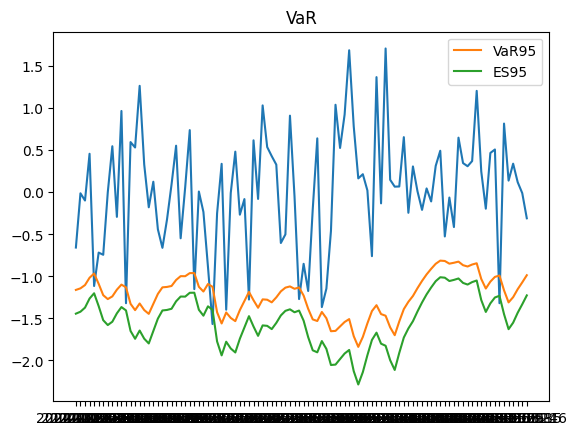

In [346]:
tail = 100
plt.plot(spy['Price'][-tail:],spy_r_log_s[-tail:])
plt.plot(spy['Price'][-tail:],garch_past_spy_VaR[-tail:], label='VaR95')
plt.plot(spy['Price'][-tail:],garch_past_spy_ES[-tail:], label='ES95')
plt.title("VaR")
plt.legend()
plt.show()

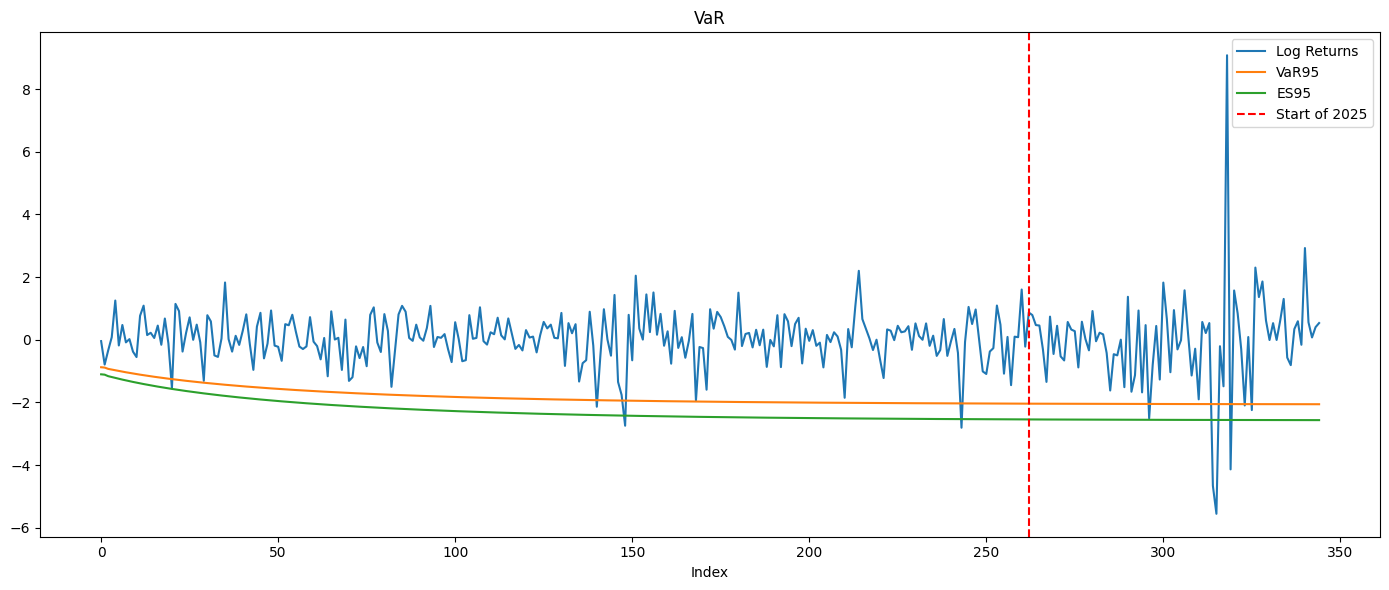

In [348]:
trading_days_2024 = pd.bdate_range(start='2024-01-01', end='2024-12-31')
start_2025_index = len(trading_days_2024)

plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(spy_test_r_log)), spy_test_r_log_s, label='Log Returns')
plt.plot(np.arange(len(future_spy_VaR)), garch_future_spy_VaR, label='VaR95')
plt.plot(np.arange(len(future_spy_ES)), garch_future_spy_ES, label='ES95')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title("VaR")
plt.xlabel("Index")
plt.legend()
plt.tight_layout()
plt.show()